## Time Frequency Analysis

In [ ]:
%pip install ipympl
import numpy as np 
import scipy as sp
from scipy import signal
import sounddevice as sd
import soundfile as sf
from matplotlib import pyplot as plt
from ipywidgets import * # interactive plots
import IPython
from IPython.display import Audio, Image
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
%matplotlib ipympl

# function for reading WAV files from a URL. Must be a RAW link, not GitHub HTML
url = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/F2.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs
      


### Introduction

Time-frequency representations of signals allow us to quantify the nature of signals in terms of its spectral (frequency) variations over time. As illustrated in Fig. 1, time-frequency analysis involves the conversion of our signal in terms of time and amplitude to a "grid-like" representation where one axis represents time frames (some time segment of the signal) and the other frequency (frequency bins are simply the discrete indices corresponding to each of the frequencies). At each of these time-frequency points, we can define some quantity which tells us something about the strength of the signal at those times and frequencies, e.g., a power spectral density. 


<br>
<br>

<div>
<center> <img src="img/time_freq.png" width="650"/> <center/>
    <p style="text-align:center">Fig. 1 - Time Frequency Analysis </p>
</div>

<br>
<br>


In this notebook, the time-frequency domain that will be used is the short-time Fourier transform (STFT), where the frequency scale is linear, meaning that there is a constant difference between adjacent frequency bins (i.e. each of the grid points in Fig. 1 is uniformly spaced in frequency). Other time-frequency transforms may however use non-linear frequency scales such as the Mel scale or the equivalent rectangular bandwidth (ERB) scale. The "best" frequency scale used depends on the application at hand.  

### Short time Fourier Transform (STFT)

Fig. 2 depicts the processing steps to obtain the STFT representation from the discrete-time domain signal. The upper-most plot of Fig. 2 depicts the captured discrete-time domain signal. In the second step, this discrete-time domain signal is segmented into fixed-length overlapping frames each consisting of $N$ samples, which are then multiplied by an analysis window,  $w[n]$. Therefore, the $l^{th}$ time
frame depicted in the third sequence of Fig. 2 can be defined as:

\begin{equation}
     \bar{y} [n, l] = y[n + lR]  w[n]
\end{equation}
for $n =  [0, 1, . . . , N − 1]$,  $l = [0, 1, . . . , L − 1]$, where L is the total number
of frames, and R is the hop-size in samples. R directly defines the amount of overlap, for instance, if R = 256 and P = 512, then the amount of overlap is defined as 50%.

The final step of then involves taking a discrete Fourier transform (DFT) on each of these windowed frames,  $\bar{y} [n, l]$, which yields complex-valued STFT coefficients:
\begin{equation}
Y(k,l) = \sum_{n=0}^{N-1} \bar{y} [n, l] e^{-j 2\pi \frac{n k}{N}}
\end{equation}

where N is the total number of frequency bins (i.e. the same as the number of samples within each frame), and $k =  [0, 1, . . . , N − 1]$ is a frequency bin corresponding to the specific frequency, f(Hz):
\begin{equation}
f = \frac{k f_s}{N}
\end{equation}
where $f_s$ is the sampling frequency (Hz).

<br>
<br>

<div>
<center> <img src="img/stft_process.png" width="650"/> <center/>
    <p style="text-align:center">Fig. 2 - Short time Fourier Transform (STFT) process </p>
</div>

<br>
<br>


Text(0, 0.5, 'Amplitude')

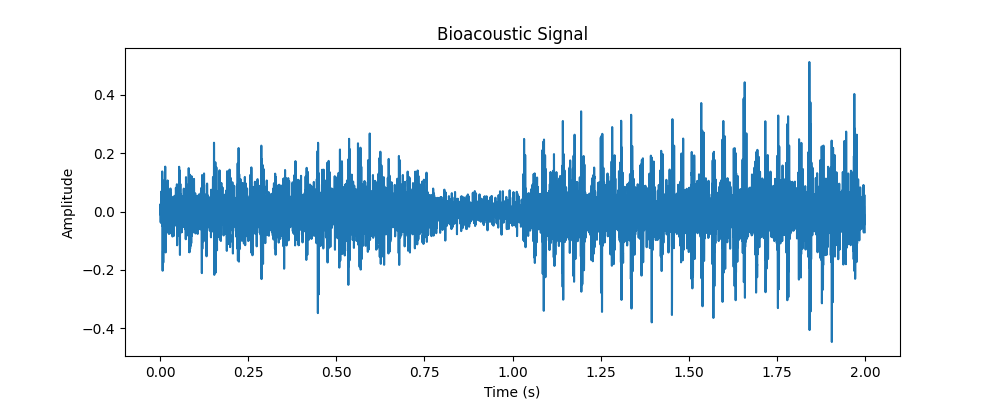

In [ ]:
# Import  signal
yy, fs = await read_wav_from_url(url)
yy = yy - np.mean(yy) # Removing the mean of the signal

t = np.arange(0,len(yy),1)*(1/fs) # time vector

IPython.display.display(Audio(yy.T, rate=fs))
      
fig, axes = plt.subplots() 
axes.plot(t, yy)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Amplitude')
plt.show()

### Spectrograms and Time/Frequency Resolution

Okay, so we have imported a bioacoustic signal and we know the sampling frequency of the signal. The next step is to compute the STFT of the signal. Luckily there are some built-in python functions to do that for us (although you could go ahead and build your own function). We will use the "scipy.signal.spectrogram" function. Upon computing the STFT of the signal, the result can be plotted in what we usually call a **Spectrogram**, where the magnitude or magnitude-squared of the DFT coefficients are displayed as a colourmap over time and frequency. 

One of the parameters we need to choose before computing the STFT however, is the length of the time frames, $N$ (i.e. the number of samples over which we compute the DFT, see Fig. 2). Recalling our previous formula for the frequency, $f = kf_{s}/N$, for $k =  [0, 1, . . . , N − 1]$, we can define the frequency resolution, i.e. the spacing between each freuqency bin as:

\begin{equation}
df = \frac{f}{k} = \frac{f_{s}}{N}
\end{equation}

This equation tells us that we can essentially increase our frequency resolution by reducing the sampling frequency, $f_s$ or by increasing the number of of samples in each time frame, $N$. However, by increasing $N$, this will reduce the temporal resolution as each time frame will now be separated by more time, and hence fast, transient events may become difficult to visualize. This is the inherent time-frequency resolution trade-off that is encountered with the STFT, i.e. as frequency resolution increases, temporal resolution decreases and vice versa.

Let's have a look at the interactive plot below to see the impact of this, and we will also control the level of overlap to see how this will impact the spectrogram.


Move the slider to see the spectrogram for different values of nfft and noverlap:


interactive(children=(IntSlider(value=1024, description='N', max=2048, min=32, step=8), FloatSlider(value=0.5,…

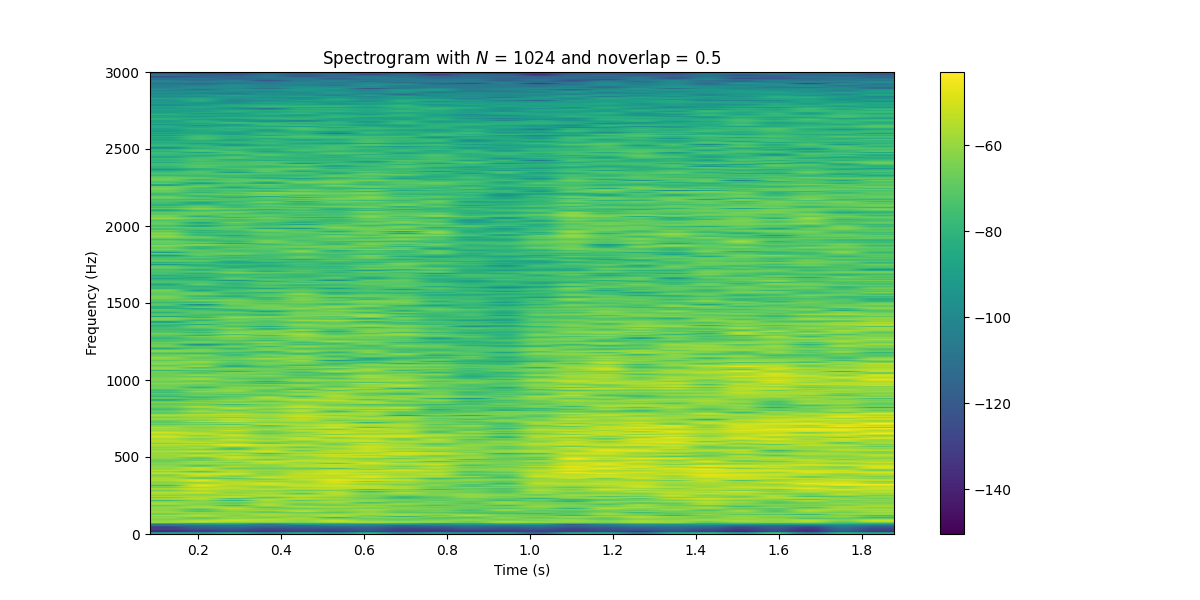

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6)) 

# Computing the spectrogram. We use the package signal which has a spectrogram function
N = 1024        # number of points for the FFT 
noverlap = 0.5      # Spectrogram overlap (make it 50 % initially)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
# A window is usually applied to the smaller time chunks to reduce any high frequency artifcats. 
# The segments are also usually overlapped to smooth out the temporal variations

f_sg, t_sg, Z_mag = signal.spectrogram(yy, fs=fs,nperseg=N,window='hann',mode='magnitude',noverlap=noverlap*N)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB

# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"
sp = axes.imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes.set_xlabel('Time (s)')
axes.set_ylabel('Frequency (Hz)')

cb = plt.colorbar(sp,ax=[axes],location='right')


# The interactive plot:
def update(N = 1024, noverlap = 0.5):

    f_sg, t_sg, Z_mag = signal.spectrogram(yy, fs=fs,nperseg=N,window='hann',mode='magnitude',noverlap=noverlap*N)
    Z_dB = 10*np.log10(Z_mag**2) 
    fig.canvas.draw_idle()
    axes.set_title('Spectrogram with $N$ = '+ str(N)+ ' and noverlap = '+ str(np.round(noverlap,decimals=1)))
    sp.set_data(Z_dB)

print('Move the slider to see the spectrogram for different values of nfft and noverlap:')
interact(update, N = (2**5,2**11,2**3), noverlap =(0.1, 0.9,0.1));

IPython.display.display(Audio(yy.T, rate=fs))


5.859375
Move the slider to see the spectrogram for different values of nfft and noverlap:


interactive(children=(IntSlider(value=0, description='start', max=10976, step=1024), FloatSlider(value=0.5, de…

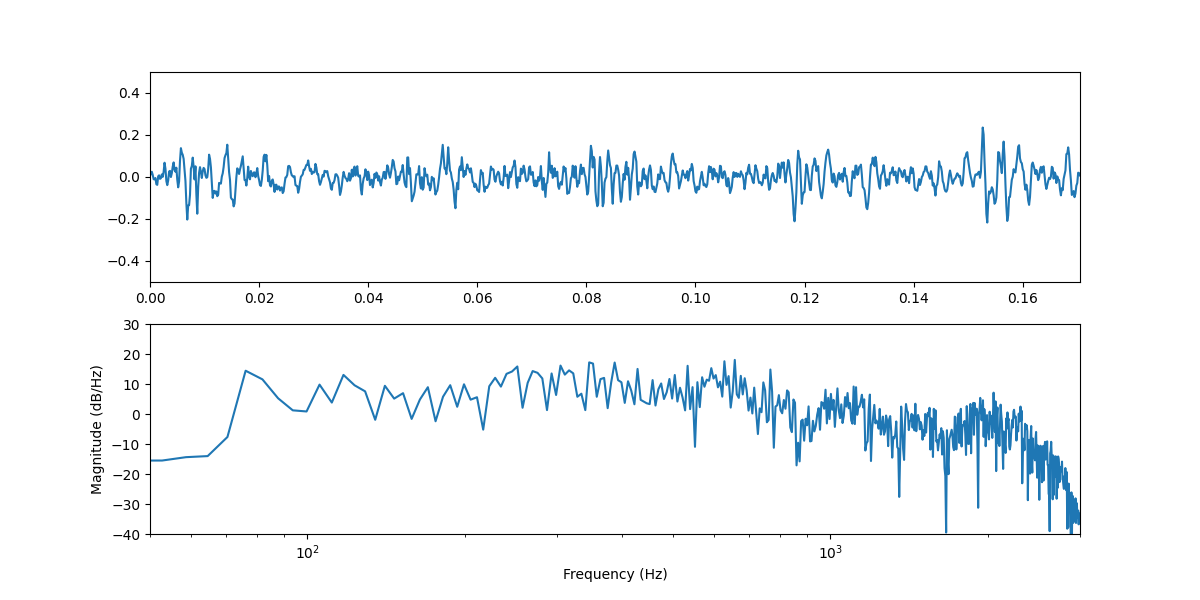